In [1]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
import tensorflow as tf
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,LearningRateScheduler
from tqdm import tqdm_notebook as tqdm

%matplotlib inline

Using TensorFlow backend.


Set random seed for reproducibility.

In [2]:
np.random.seed(2020)
tf.set_random_seed(2020)

# Loading & Exploration

In [3]:
train_df = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
test_df = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')
print(train_df.shape)
print(test_df.shape)
train_df.head()

(3662, 2)
(1928, 1)


,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

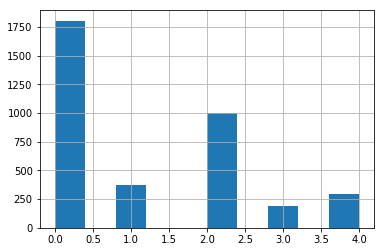

In [4]:
train_df['diagnosis'].hist()
train_df['diagnosis'].value_counts()

### Displaying some Sample Images

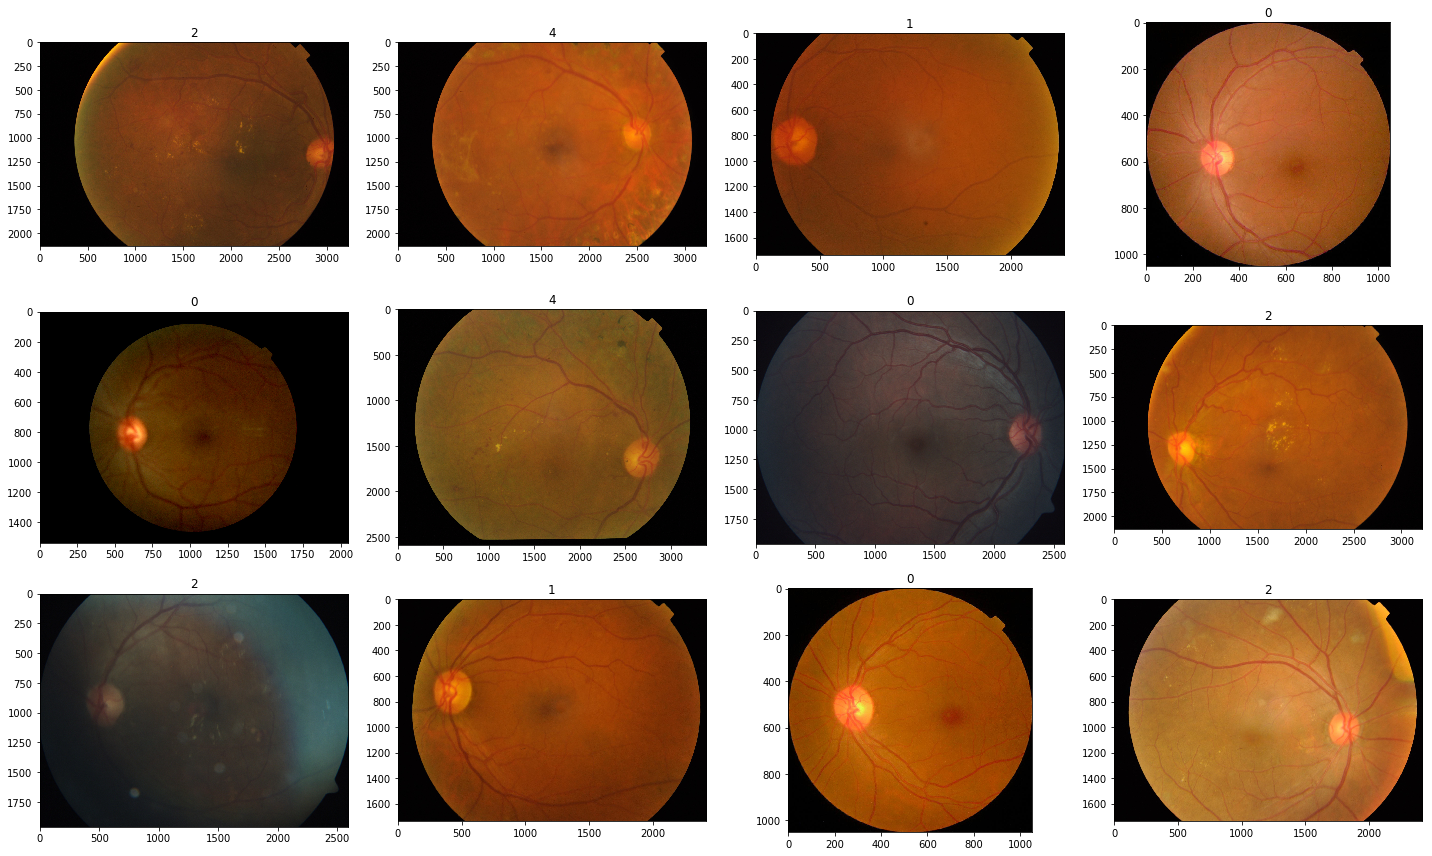

In [5]:
def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'id_code']
        image_id = df.loc[i,'diagnosis']
        img = cv2.imread(f'../input/aptos2019-blindness-detection/train_images/{image_path}.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)
    
    plt.tight_layout()

display_samples(train_df)

# Resize Images

We will resize the images to 456x456, then create a single numpy array to hold the data.

In [6]:
# image height and image width ----> GLOBAL
img_ht = 224
img_wd = 224

def displayImage(display_name, image):
    cv2.namedWindow(display_name,cv2.WINDOW_AUTOSIZE)
    cv2.imshow(display_name, image)

def findContourEye(thresh_image):
    cnts = cv2.findContours(thresh_image.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
#     cnts = imutils.grab_contours(cnts)
    cnts = max(cnts[0], key=cv2.contourArea)
    return cnts

def findContourEyeExtreme(cnts):
    # Locating extreme points on all 4 sides
    leftmost = tuple(cnts[cnts[:,:,0].argmin()][0])
    rightmost = tuple(cnts[cnts[:,:,0].argmax()][0])
    topmost = tuple(cnts[cnts[:,:,1].argmin()][0])
    bottommost = tuple(cnts[cnts[:,:,1].argmax()][0])
    # Locating the top left and bottom right corner
    x1 = leftmost[0]
    y1 = topmost[1]
    x2 = rightmost[0]
    y2 = bottommost[1]
    return x1,y1,x2,y2 

def findRadiusAndCentreOfContourEye(cnts):
    M = cv2.moments(cnts)
    if( M["m00"]==0):
        cX, cY = 0, 0
    else:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    if(cX < cY):
        r = cX
    else:
        r = cY
    return cX,cY,r

def drawCentreOnContourEye(image,cnts,cX,cY):
    cv2.drawContours(image, [cnts], -1, (0, 255, 0), 2)
    cv2.circle(image, (cX, cY), 7, (255, 255, 255), -1)
    cv2.putText(image, "center", (cX - 20, cY - 20),
    cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2)
    return image
    
def Radius_Reduction(img,cX,cY,r):
    h,w,c=img.shape
    Frame=np.zeros((h,w,c),dtype=np.uint8)
    cv2.circle(Frame,(int(cX),int(cY)),int(r), (255,255,255), -1)
    Frame1=cv2.cvtColor(Frame, cv2.COLOR_BGR2GRAY)
    img1 =cv2.bitwise_and(img,img,mask=Frame1)
    return img1

def imageResize(image, ht, wd):
    # resized_image = imutils.resize(image, height = ht, width = wd)
    resized_image = cv2.resize(image,(wd,ht))
    return resized_image

def crop_black(image):
    org = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    thresh = cv2.threshold(blurred, 10, 255, cv2.THRESH_BINARY)[1]
    # displayImage('thresh',thresh)
    cnts = findContourEye(thresh)
    x1,y1,x2,y2 = findContourEyeExtreme(cnts)
    # print(x1,y1,x2,y2)
    crop = org[y1:y2, x1:x2]
    crop = imageResize(crop, img_ht, img_wd)
    # displayImage("cr1",crop)
    return crop

def imageAugmentation(image):
    x_flip = cv2.flip( image, 0 )
    y_flip = cv2.flip( image, 1 )
    xy_flip = cv2.flip(x_flip,1)
    return x_flip, y_flip, xy_flip

def imageHistEqualization(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl,a,b))
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    return final

def subtract_median_bg_image(im):
    k = np.max(im.shape)//20*2+1
    bg = cv2.medianBlur(im, k)
    sub_med = cv2.addWeighted (im, 4, bg, -4, 255)
    return sub_med

def colorEnhancement(image1,image2):
    image_final = cv2.bitwise_and(image1,image2)
    return image_final

def imageAugSave(path,img1,img2,img3,img4,img_ht,img_wd):
    count = len(os.listdir(path))

    img1 = imageResize(img1, img_ht, img_wd)
    img2 = imageResize(img2, img_ht, img_wd)
    img3 = imageResize(img3, img_ht, img_wd)
    img4 = imageResize(img4, img_ht, img_wd)

    cv2.imwrite(os.path.join(path , '%d.png'%(count+1)), img1)
    cv2.imwrite(os.path.join(path , '%d.png'%(count+2)), img2)
    cv2.imwrite(os.path.join(path , '%d.png'%(count+3)), img3)
    cv2.imwrite(os.path.join(path , '%d.png'%(count+4)), img4)
    return count+1,count+2,count+3,count+4

def processed_test_save(path,img,img_ht,img_wd):
    count = len(os.listdir(path))
    img = imageResize(img,img_ht,img_wd)
    cv2.imwrite(os.path.join(path , '%d.png'%(count+1)), img)
    return count+1

In [7]:
def get_pad_width(im, new_shape, is_rgb=True):
    pad_diff = new_shape - im.shape[0], new_shape - im.shape[1]
    t, b = math.floor(pad_diff[0]/2), math.ceil(pad_diff[0]/2)
    l, r = math.floor(pad_diff[1]/2), math.ceil(pad_diff[1]/2)
    if is_rgb:
        pad_width = ((t,b), (l,r), (0, 0))
    else:
        pad_width = ((t,b), (l,r))
    return pad_width

def preprocess_image_YY(image_path, desired_size=224):
    image = cv2.imread(image_path)
    image = imageResize(image, desired_size, desired_size)
    image_crop = crop_black(image)
    image_clahe = imageHistEqualization(image_crop)
    sub_med = subtract_median_bg_image(image_clahe)
    image_final = colorEnhancement(sub_med, image_clahe)
    return image_final

def preprocess_image(image_path, desired_size=224):
    im = Image.open(image_path)
    im = im.resize((desired_size, )*2, resample=Image.LANCZOS)
    im = np.array(im)
    im = cv2.cvtColor(im,cv2.COLOR_RGB2BGR)
    image_crop = crop_black(im)
    image_clahe = imageHistEqualization(image_crop)
    sub_med = subtract_median_bg_image(image_clahe)
    image_final = colorEnhancement(sub_med, image_clahe)
    image_final = image_crop
    im =  cv2.cvtColor(image_final,cv2.COLOR_BGR2RGB)
    return im

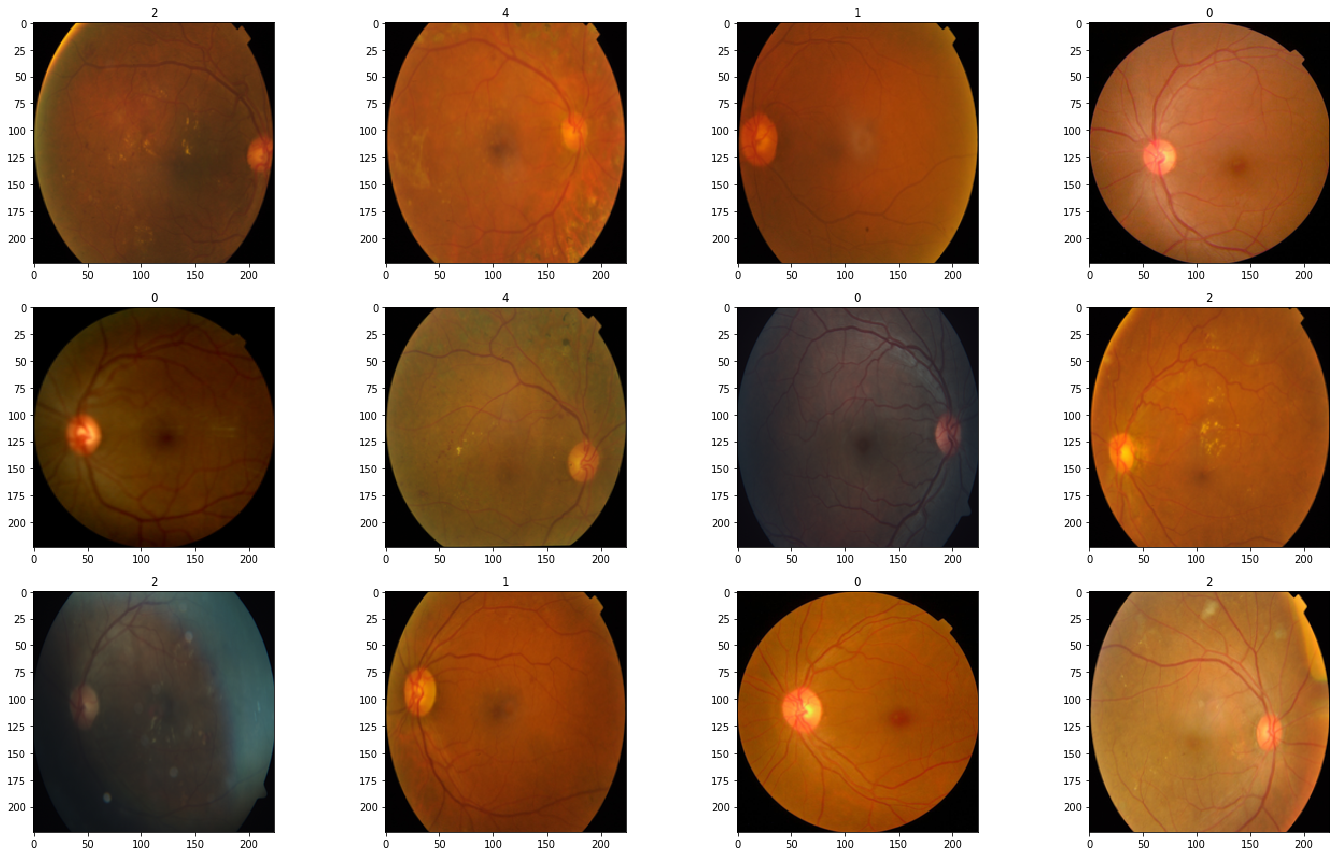

In [8]:
def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'id_code']
        image_id = df.loc[i,'diagnosis']
        img = preprocess_image(f'../input/aptos2019-blindness-detection/train_images/{image_path}.png')
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)
    
    plt.tight_layout()

display_samples(train_df)

In [9]:
N = train_df.shape[0]
x_train = np.empty((N, img_ht, img_wd, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(train_df['id_code'])):
    x_train[i, :, :, :] = preprocess_image(
        f'../input/aptos2019-blindness-detection/train_images/{image_id}.png'
    )

In [10]:
N = test_df.shape[0]
x_test = np.empty((N, img_wd, img_ht, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(test_df['id_code'])):
    x_test[i, :, :, :] = preprocess_image(
        f'../input/aptos2019-blindness-detection/test_images/{image_id}.png'
    )

In [11]:
y_train = pd.get_dummies(train_df['diagnosis']).values

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)

(3662, 224, 224, 3)
(3662, 5)
(1928, 224, 224, 3)


## Creating multilabels

Instead of predicting a single label, we will change our target to be a multilabel problem; i.e., if the target is a certain class, then it encompasses all the classes before it. E.g. encoding a class 4 retinopathy would usually be `[0, 0, 0, 1]`, but in our case we will predict `[1, 1, 1, 1]`. For more details, please check out [Lex's kernel](https://www.kaggle.com/lextoumbourou/blindness-detection-resnet34-ordinal-targets).

In [12]:
y_train_multi = np.empty(y_train.shape, dtype=y_train.dtype)
y_train_multi[:, 4] = y_train[:, 4]

for i in range(3, -1, -1):
    y_train_multi[:, i] = np.logical_or(y_train[:, i], y_train_multi[:, i+1])

print("Original y_train:", y_train.sum(axis=0))
print("Multilabel version:", y_train_multi.sum(axis=0))

Original y_train: [1805  370  999  193  295]
Multilabel version: [3662 1857 1487  488  295]


Now we can split it into a training and validation set.

In [13]:
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train_multi, 
    test_size=0.15, 
    random_state=2019
)

#  Data Generator

In [14]:
BATCH_SIZE = 4

def create_datagen():
    return ImageDataGenerator(
        zoom_range=0.15,  # set range for random zoom
        # set mode for filling points outside the input boundaries
        fill_mode='constant',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
        width_shift_range = 0.3,
        height_shift_range=0.3
    )

# Using original generator
data_generator = create_datagen().flow(x_train, y_train, batch_size=BATCH_SIZE, seed=2020)
# Using Mixup
# mixup_generator = MixupGenerator(x_train, y_train, batch_size=BATCH_SIZE, alpha=0.2, datagen=create_datagen())()

### Creating keras callback for QWK

In [15]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.validation_data[:2]
        y_val = y_val.sum(axis=1) - 1
        
        y_pred = self.model.predict(X_val) > 0.5
        y_pred = y_pred.astype(int).sum(axis=1) - 1

        _val_kappa = cohen_kappa_score(
            y_val,
            y_pred, 
            weights='quadratic'
        )

        self.val_kappas.append(_val_kappa)

        print(f"val_kappa: {_val_kappa:.4f}")
        
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save('model.h5')

        return

# Model: DenseNet-121

In [16]:
cnn_net = DenseNet121(
    weights='../input/densenet-keras/DenseNet-BC-121-32-no-top.h5',
    include_top=False,
    input_shape=(img_wd,img_ht,3)
)

# Efficienetnet

In [17]:
# import gc
# gc.collect()
# import os
# import sys
# # Repository source: https://github.com/qubvel/efficientnet
# sys.path.append(os.path.abspath('../input/efficientnet/efficientnet-master/efficientnet-master/'))
# from efficientnet import EfficientNetB4
# # Load in EfficientNetB5
# cnn_net = EfficientNetB5(weights=None,
#                         include_top=False,
#                         input_shape=(img_wd, img_ht, 3))
# cnn_net.load_weights('../input/efficientnet-keras-weights-b0b5/efficientnet-b4_imagenet_1000_notop.h5')

In [18]:
def build_model():
    model = Sequential()
    model.add(cnn_net)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=0.00005),
        metrics=['accuracy']
    )
    
    return model

In [19]:
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 5125      
Total params: 7,042,629
Trainable params: 6,958,981
Non-trainable params: 83,648
_________________________________________________________________


# Training & Evaluation

In [20]:
es = EarlyStopping(monitor='val_loss',
                                      mode='auto',
                                      verbose=1,
                                      patience=10)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            mode = 'auto',
                                            factor=0.25,
                                            min_lr=0.000001)


In [21]:
kappa_metrics = Metrics()

history = model.fit_generator(
    data_generator,
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=15,
    validation_data=(x_val, y_val),
    callbacks=[kappa_metrics,es, learning_rate_reduction]
)

Epoch 1/15
778/778 [==============================] - 168s 216ms/step - loss: 0.3076 - acc: 0.8722 - val_loss: 0.1829 - val_acc: 0.9273
val_kappa: 0.7761
Validation Kappa has improved. Saving model.
Epoch 2/15
778/778 [==============================] - 129s 166ms/step - loss: 0.2408 - acc: 0.9044 - val_loss: 0.1136 - val_acc: 0.9567
val_kappa: 0.9050
Validation Kappa has improved. Saving model.
Epoch 3/15
778/778 [==============================] - 128s 165ms/step - loss: 0.2189 - acc: 0.9166 - val_loss: 0.1118 - val_acc: 0.9589
val_kappa: 0.8997
Epoch 4/15
778/778 [==============================] - 126s 162ms/step - loss: 0.2064 - acc: 0.9204 - val_loss: 0.1123 - val_acc: 0.9585
val_kappa: 0.8971
Epoch 5/15
778/778 [==============================] - 132s 170ms/step - loss: 0.1901 - acc: 0.9269 - val_loss: 0.1185 - val_acc: 0.9593
val_kappa: 0.8954
Epoch 6/15
778/778 [==============================] - 133s 171ms/step - loss: 0.1780 - acc: 0.9341 - val_loss: 0.1070 - val_acc: 0.9604
val_

In [22]:
with open('history.json', 'w') as f:
    try:
        json.dump(history.history, f)
    except:
        pass


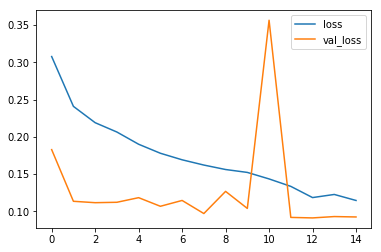

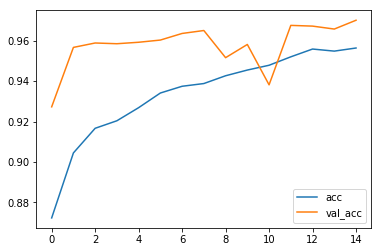

In [23]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()

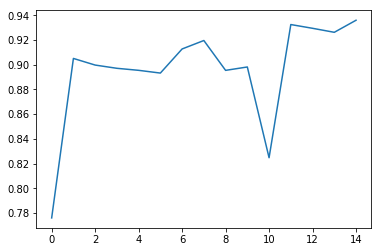

In [24]:
plt.plot(kappa_metrics.val_kappas)

## Submit

In [26]:
y_test = model.predict(x_test) > 0.5
y_test = y_test.astype(int).sum(axis=1) - 1

test_df['diagnosis'] = y_test
test_df.to_csv('submission.csv',index=False)